In [53]:
from Dataset.BAFADataset import TFDataset as DataGenerator
from utils.config import process_config
from matplotlib import pyplot as plt
import tensorflow as tf

import argparse
import numpy as np

tf.executing_eagerly()
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [240]:
config = process_config('config/paf_configuration.json')
train_data_generator = DataGenerator(config, 'train')

dataset = iter(train_data_generator())
x,y = next(dataset)
print(x.shape)
print(y[0].shape)
print(y[1].shape)

(32, 96, 96, 3)
(32, 96, 96, 11)
(32, 60, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(60, 2)


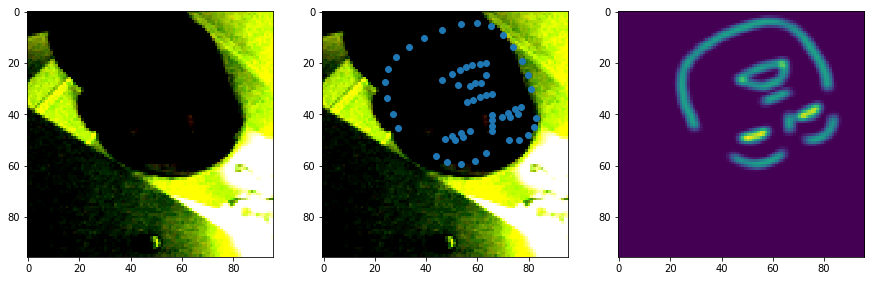

In [241]:
fig, axes = plt.subplots(1,3,figsize=(15,15))
axes[0].imshow(x[0])
axes[1].imshow(x[0])
print(y[1][0].shape)
xl,yl = np.transpose(y[1][0])
axes[1].scatter(xl,yl)
axes[2].imshow(np.sum(y[0][0], -1))

In [247]:
def points_in_circle_np(radius):
    a = np.arange(radius + 1)
    for x, y in zip(*np.where(a[:,np.newaxis]**2 + a**2 <= radius**2)):
        yield from set(((x, y), (x, -y), (-x, y), (-x, -y),))
        
# lms = 60,2
def create_paf(img, lms):
    paf = np.zeros((2,96,96))
    total_points = np.array([]).reshape(0,2)
    bound = np.array(list(points_in_circle_np(1)))
    pl = [16,26,35,41,47,59]
    for i in range(len(lms)-1):
        if i in pl:
            continue
        px, py = lms[i+1] - lms[i]
        length = np.sqrt(px**2+py**2)
        unit_px, unit_py = px/length, py/length
        x, y = lms[i]
        x_n, y_n = lms[i+1]
        xlist = np.linspace(x,x_n,int(length)+1).astype(int)
        xlist = np.expand_dims(xlist, axis=0)
        ylist = np.linspace(y,y_n,int(length)+1).astype(int)
        ylist = np.expand_dims(ylist, axis=0)
        points = np.concatenate((xlist, ylist))
        points = np.transpose(points)
        points = np.array([points[i]+bound for i in range(points.shape[0])])
        points = points.reshape(-1,2)
        points = np.unique(points, axis=0)
        
        dr = []
        for i, row in enumerate(points):
            xp, yp = row
            if xp>= 96 or xp<0 or yp>= 96 or yp<0:
                dr.append(i)
                continue
            paf[0][xp][yp] = unit_px
            paf[1][xp][yp] = unit_py

        points = np.delete(points,dr,0)
        total_points = np.vstack((total_points, points))
            
    total_points = np.unique(total_points, axis=0).astype(int)
    return paf, total_points
        
    
fig, ax = plt.subplots(3,2,figsize=(200,200))
for f in range(3):
    img = x[f]
    lms = y[1][f]
    lanx, lany = np.transpose(lms)
    lanx, lany = lanx.astype(int), lany.astype(int)
    keyx, keyy = lanx, lany

    lanx, lany = lanx[lanx<96], lany[lanx<96]
    lanx, lany = lanx[lany<96], lany[lany<96]

    keyx = keyx[[0,8,16,17,21,22,26,27,36,39,42,45,48,54]]
    keyy = keyy[[0,8,16,17,21,22,26,27,36,39,42,45,48,54]]
    keyx, keyy = keyx[keyx<96], keyy[keyx<96]
    keyx, keyy = keyx[keyy<96], keyy[keyy<96]

    paf, total_points = create_paf(img, lms)
    xl = [el[0] for el in total_points]
    yl = [el[1] for el in total_points]
    for i in range(2):
        if i == 0:
            ax[f][i].imshow(img)
        if i == 1:
            img = np.zeros([100,100,3],dtype=np.uint8)
            img.fill(255)
            ax[f][i].imshow(img)
        #ax[f][i].quiver(xl,yl,paf[0][xl, yl],-paf[1][xl, yl], scale_units='xy', scale=1, color='purple')
        ax[f][i].scatter(lanx, lany, color='r')
        ax[f][i].scatter(keyx, keyy, color='g')
        
        print(lanx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[80 79 77 73 70 65 59 53 46 39 33 28 24 23 24 26 29 82 82 79 76 72 63 59
 53 48 43 65 65 65 65 65 63 61 58 55 76 75 72 69 71 74 57 54 51 47 50 53
 63 63 61 59 57 52 46 49 53 55 57 61]
[80 79 77 73 70 65 59 53 46 39 33 28 24 23 24 26 29 82 82 79 76 72 63 59
 53 48 43 65 65 65 65 65 63 61 58 55 76 75 72 69 71 74 57 54 51 47 50 53
 63 63 61 59 57 52 46 49 53 55 57 61]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[95 90 84 78 70 46 45 46 48 51 57 56 57 58 60 62 68 73 78 77 78 80 81 80
 54 54 56 58 59 57 64 64 65 66 67 66 81 81 83 85 85 88 91 95 95 93 89]
[95 90 84 78 70 46 45 46 48 51 57 56 57 58 60 62 68 73 78 77 78 80 81 80
 54 54 56 58 59 57 64 64 65 66 67 66 81 81 83 85 85 88 91 95 95 93 89]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[75 72 68 64 58 50 42 34 25 17 12  7  4  4  5  5  6 69 65 60 53 47 31 26
 22 17 13 35 34 33 32 38 34 31 28 25 59 55 51 47 50 55 27 24 19 16 19 23
 41 36 32 29 27 23 19 22 25 27 30 35]
[75 72 68 64 58 50 42 34 25 17 12  7  4  4  5  5  6 69 65 60 53 47 31 26
 22 17 13 35 34 33 32 38 34 31 28 25 59 55 51 47 50 55 27 24 19 16 19 23
 41 36 32 29 27 23 19 22 25 27 30 35]


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


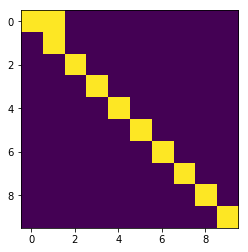

In [76]:
a= np.eye(10,10)
print(a)
plt.imshow(a)
a[0][1] = 1
plt.imshow(a)

In [83]:
1e-5*1000

0.01

In [127]:
def points_in_circle_np(radius):
    a = np.arange(radius + 1)
    for x, y in zip(*np.where(a[:,np.newaxis]**2 + a**2 <= radius**2)):
        yield from set(((x, y), (x, -y), (-x, y), (-x, -y),))

a = points_in_circle_np(2)

In [128]:
print(a)
aa = np.array(list(a))

<generator object points_in_circle_np at 0x7efa9c18a0a0>


In [130]:
np.add((1,1),aa)

array([[ 1,  1],
       [ 1,  2],
       [ 1,  0],
       [ 1, -1],
       [ 1,  3],
       [ 2,  1],
       [ 0,  1],
       [ 0,  2],
       [ 2,  0],
       [ 2,  2],
       [ 0,  0],
       [ 3,  1],
       [-1,  1]])

In [129]:
aa

array([[ 0,  0],
       [ 0,  1],
       [ 0, -1],
       [ 0, -2],
       [ 0,  2],
       [ 1,  0],
       [-1,  0],
       [-1,  1],
       [ 1, -1],
       [ 1,  1],
       [-1, -1],
       [ 2,  0],
       [-2,  0]])